# DCN Goodreads Recommendation System

---
## Prepare the Data

Setup

In [1]:
import json
import os
import numpy as np
import pandas as pd
from IPython.display import display
import pprint
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import layers


Dataset Directory

In [2]:
DIR = './data/cleaned/'
fn_books = 'goodreads_books_mystery_thriller_crime.pkl'
fn_reviews = 'goodreads_reviews_mystery_thriller_crime.pkl'
fn_genres = 'goodreads_book_genres_initial.pkl'

In [3]:
df_reviews = pd.read_pickle(os.path.join(DIR, fn_reviews))
df_books = pd.read_pickle(os.path.join(DIR, fn_books))
df_genres = pd.read_pickle(os.path.join(DIR, fn_genres))

In [64]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 250000 entries, 5333265 to 2356633
Data columns (total 10 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   history, historical fiction, biography  250000 non-null  int32
 1   fiction                                 250000 non-null  int32
 2   fantasy, paranormal                     250000 non-null  int32
 3   mystery, thriller, crime                250000 non-null  int32
 4   poetry                                  250000 non-null  int32
 5   romance                                 250000 non-null  int32
 6   non-fiction                             250000 non-null  int32
 7   children                                250000 non-null  int32
 8   young-adult                             250000 non-null  int32
 9   comics, graphic                         250000 non-null  int32
dtypes: int32(10)
memory usage: 11.4 MB


In [4]:
df_join = pd.merge(df_reviews, df_books, left_on="book_id", right_index=True)
df_join.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,popular_shelves,average_rating,description,author_id,author_name
review_id,,,,,,,,,,,
0e317947e1fd341f573192111bb2921d,8842281e1d1347389f2ab93d60773d4d,8694005,3,The Name of the Rose is a thrilling Dan Brown-...,b'The Name of the Rose',99,"[{'count': '8209', 'name': 'to-read'}, {'count...",4.11,The year is 1327. Franciscans in a wealthy Ita...,1730,Umberto Eco
4276918357312212384ac6415ceb9159,8842281e1d1347389f2ab93d60773d4d,6652906,3,** spoiler alert ** Hooked me equally as wel...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
9ee704921386f88893900829c037abd0,4fdf8e419e36ae2e82bc44376768e280,6652906,4,Don't start these books unless you're ready to...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
26e59823f1936fe9030d85262f1477e1,446728d221c1343b92e1e4ff5545a843,6652906,5,Loved it! Not as much as the first but it this...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
83370bd38023a2fd928b2b6114c2b210,fe0ad83a30bcd7fbe65ac1670b2b01e1,6652906,5,Once again Larsson does not disappoint. Althou...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson


In [5]:
df_join = pd.merge(df_join, df_genres, left_on="book_id", right_index=True)
df_join.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,popular_shelves,average_rating,description,author_id,...,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,,
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,3,"** spoiler alert ** Critics aside, Dan Brown...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
41e98a56ec0abd77d9191b4f1e2cd806,40b795551cd5b1dae85ff2f7b8ddee27,6411961,2,"While the book is a page-turner, I found the p...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
9ccb9f3b2719283bd8a6d24c297cd738,2193b39163317f53641d1f8539a4586c,6411961,3,As always well written and you have to keep re...,"b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
a4f43a0a2703c9c46a18ba1b8a7a2b90,21e67f8f9a1679070e93ff8a152efde6,6411961,3,"I am sorry to say this, but i found the plot o...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
0b8368d5286c6ebf3a22a7ed3572b513,1939a0e8cacc2101a1f6d5446d91de78,6411961,4,"Book two - loved it, couldn't put down until I...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0


In [6]:
df_join.describe()

,book_id,rating,text_reviews_count,average_rating,author_id,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
count,1.089900e+04,10899.000000,10899.000000,10899.000000,1.089900e+04,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000
mean,1.271280e+07,3.718873,1922.866869,3.863832,2.223974e+06,38.609964,602.765850,28.801633,1117.014038,0.022846,19.107533,5.644830,2.619782,30.007524,0.068171
std,1.057604e+07,1.164748,4954.590599,0.287245,3.700216e+06,161.711543,1639.162593,121.687751,2647.616474,0.826881,79.539608,158.885851,46.250787,204.250718,1.743413
min,2.300000e+02,0.000000,1.000000,2.190000,1.310000e+02,-1.000000,-1.000000,-4.000000,2.000000,0.000000,-3.000000,-1.000000,0.000000,-1.000000,-2.000000
25%,1.244206e+06,3.000000,34.000000,3.700000,1.706250e+04,0.000000,13.000000,0.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.277838e+07,4.000000,187.000000,3.890000,1.565230e+05,0.000000,68.000000,0.000000,210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.129745e+07,5.000000,1043.000000,4.060000,3.317636e+06,0.000000,318.000000,0.000000,836.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,3.640284e+07,5.000000,24868.000000,4.890000,1.732060e+07,2410.000000,17771.000000,1555.000000,22104.000000,48.000000,1683.000000,8049.000000,1992.000000,2305.000000,92.000000


In [7]:
df_join.dtypes

user_id                                    object
book_id                                    uint32
rating                                      uint8
review_text                                object
title                                      object
text_reviews_count                         uint32
popular_shelves                            object
average_rating                            float64
description                                object
author_id                                   int64
author_name                                object
history, historical fiction, biography      int32
fiction                                     int32
fantasy, paranormal                         int32
mystery, thriller, crime                    int32
poetry                                      int32
romance                                     int32
non-fiction                                 int32
children                                    int32
young-adult                                 int32


In [8]:
data = df_join.drop("popular_shelves",axis='columns')

In [9]:
data.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id,author_name,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,3,"** spoiler alert ** Critics aside, Dan Brown...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
41e98a56ec0abd77d9191b4f1e2cd806,40b795551cd5b1dae85ff2f7b8ddee27,6411961,2,"While the book is a page-turner, I found the p...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
9ccb9f3b2719283bd8a6d24c297cd738,2193b39163317f53641d1f8539a4586c,6411961,3,As always well written and you have to keep re...,"b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
a4f43a0a2703c9c46a18ba1b8a7a2b90,21e67f8f9a1679070e93ff8a152efde6,6411961,3,"I am sorry to say this, but i found the plot o...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
0b8368d5286c6ebf3a22a7ed3572b513,1939a0e8cacc2101a1f6d5446d91de78,6411961,4,"Book two - loved it, couldn't put down until I...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0


In [10]:
data.iloc[:, 10:]

,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,
d44b6d28f456dbcc5b1537b4c5572400,861,6059,115,8244,0,0,0,0,0,0
41e98a56ec0abd77d9191b4f1e2cd806,861,6059,115,8244,0,0,0,0,0,0
9ccb9f3b2719283bd8a6d24c297cd738,861,6059,115,8244,0,0,0,0,0,0
a4f43a0a2703c9c46a18ba1b8a7a2b90,861,6059,115,8244,0,0,0,0,0,0
0b8368d5286c6ebf3a22a7ed3572b513,861,6059,115,8244,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
612e189a0add073560afceacbd45013d,0,5,0,59,0,2,0,0,0,0
678dd627b20d421c53723728cf9426e1,0,494,0,934,0,0,0,0,0,0
cecb79b73acb8aab56231ccf332ec5aa,1,27,0,19,0,1,0,0,0,0


In [56]:
data.sample(5)

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id,author_name,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,
a20a10df4d321dd1bb82123c3262fd06,49a744b185c182d4840c7feeaefbea6f,13593563,5,Another stellar outing for basketballer Mickey...,"b'Seconds Away (Mickey Bolitar, #2)'",714,4.02,This action-packed second book in internationa...,24689,Harlan Coben,0,90,0,357,0,3,0,0,164,0
ec5bdd7ec2c5c8976b7d5a724cc3c540,6e033e44e3663b81be2d6e23d68d018a,28114478,4,Delightful!,"b'Lady Cop Makes Trouble (Kopp Sisters, #2)'",650,3.81,After besting (and arresting) a ruthless silk ...,34893,Amy Stewart,327,410,0,271,0,0,0,0,0,0
0d0261f62490363caa0237cfce43888e,e971c1c945f3626567b220987eaabcf1,26209470,5,Love and betrayal served on a hefty slice of k...,b'Grave of Hummingbirds',15,3.33,"In the remote Andean village of Colibri, a boy...",8007733,Jennifer Skutelsky,0,27,17,30,0,0,0,0,0,0
6119831b145db70890c24a34f1738d91,60dc085f04d6282997797a55f3fbc541,31193588,5,Dark and unpredictable. Unnatural Deeds tota...,b'Unnatural Deeds',11,3.71,Secrets. Obsession. Murder. Victoria is about ...,1463436,Cyn Balog,0,13,2,84,0,5,0,0,61,0
dbff60a579bf378dc2ec901d05dbd570,909b4f91cb4d06d7ed3e2df3a6a0495f,57864,1,"This is an awful, awful, and cliched book, wit...",b'Tokyo Suckerpunch',50,3.71,"Meet Billy Chaka, ace reporter for Cleveland's...",32584,Isaac Adamson,0,33,1,13,0,0,0,0,0,0


Let's split the data into training (80%) and test (20%) sets.

In [59]:
TARGET_FEATURE_NAME = "rating"  # individual rating
split = 0.8

In [60]:
train_splits = []
test_splits = []

for _, group_data in data.groupby(TARGET_FEATURE_NAME):
    random_selection = np.random.rand(len(group_data.index)) <= split
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")


Train split size: 8796
Test split size: 2103


Durch den Merge wurden aus (50k Büchern ∩ 100k Reviews ∩ 250k Genres) ≅ 10k kombinierte Datenpunkte!

In [67]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(os.path.join(DIR, train_data_file), index=False)
test_data.to_csv(os.path.join(DIR, test_data_file), index=False)

In [71]:
CSV_HEADER = list(train_data.columns)

---
## Define dataset metadata
Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.



In [72]:
TARGET_FEATURE_LABELS = [i for i in range(6)]
# normalization
NUMERIC_FEATURE_NAMES = [
    "text_reviews_count",   # popularity
    "average_rating"
]
# text vectorization + embedding
TEXT_FEATURE_NAMES = [
    "review_text",
    "title",
    "description",
    "author_name"
]
# integer lookup
CATEGORICAL_INT_FEATURE_NAMES = [
    "book_id",
    "author_id",
]
# string lookup
CATEGORICAL_STR_FEATURE_NAMES = [
    "user_id",
]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(data["user_id"].unique()),
    "author_id": list(data["author_id"].unique()),
    "book_id": list(data["book_id"].unique()),
}


# integer lookup
CATEGORICAL_MULTI_HOT_FEATURE_NAMES = [
    "history, historical fiction, biography",
    "fiction",
    "fantasy, paranormal",
    "mystery, thriller, crime",
    "poetry",
    "romance",
    "non-fiction",
    "children",
    "young-adult",
    "comics, graphic"
]
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + \
                TEXT_FEATURE_NAMES + \
                CATEGORICAL_INT_FEATURE_NAMES + \
                CATEGORICAL_STR_FEATURE_NAMES + \
                CATEGORICAL_MULTI_HOT_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]


NUM_CLASSES = len(TARGET_FEATURE_LABELS)

---
## Experiment setup
Next, let's define an input function that reads and parses the file, then converts features and labels into a `tf.data.Dataset` for training or evaluation.



In [54]:
def get_dataset_from_pandas(df, label_name, batch_size, shuffle=False):
    labels = df.pop(label_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle()
    ds = ds.batch(batch_size)
    return ds.cache()

In [73]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


In [74]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    
    train_dataset = get_dataset_from_pandas(train_data, 'rating', batch_size, shuffle=True)

    test_dataset = get_dataset_from_pandas(test_data, 'rating', batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


---
## Create model inputs
Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a `keras.layers.Input` tensor with the corresponding feature shape and data type.



In [37]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string, output_mode="multi_hot"):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode=output_mode)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [49]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in [*TEXT_FEATURE_NAMES, *CATEGORICAL_STR_FEATURE_NAMES]:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
    return inputs

---
## Encode features

We create two representations of our input features: sparse and dense: 1. In the *sparse* representation, the categorical features are encoded with one-hot encoding using the `CategoryEncoding` layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the *dense* representation, the categorical features are encoded with low-dimensional embeddings using the ``Embedding`` layer. This representation helps the model to generalize well to unseen feature combinations.



In [75]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [82]:
CATEGORICAL_STR_FEATURE_NAMES

['user_id']

In [147]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in [*CATEGORICAL_STR_FEATURE_NAMES, *CATEGORICAL_INT_FEATURE_NAMES]:
            is_string = (feature_name in CATEGORICAL_STR_FEATURE_NAMES)
            lookup_class = StringLookup if is_string else IntegerLookup
            lookup_name = "string_lookup_" if is_string else "integer_lookup_"
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = lookup_class(
                vocabulary=vocabulary,
                output_mode="int" if use_embedding else "multi_hot",
                name=lookup_name+feature_name,
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims,
                    name="embedding_"+feature_name,
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        elif feature_name in TEXT_FEATURE_NAMES:
            vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features, 
            output_sequence_length=sequence_length if use_embedding else None, output_mode="int" if use_embedding else "multi_hot",
            name="textvectorization_"+feature_name,
            )
            vectorize_layer.adapt(data[feature_name])
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = vectorize_layer(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=vectorize_layer.vocabulary_size(), output_dim=embedding_dims,
                    name="embedding_"+feature_name,
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = vectorize_layer(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)
        
    all_features = layers.concatenate(encoded_features)
    return all_features


---
## Experiment 1: a baseline model
In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded.


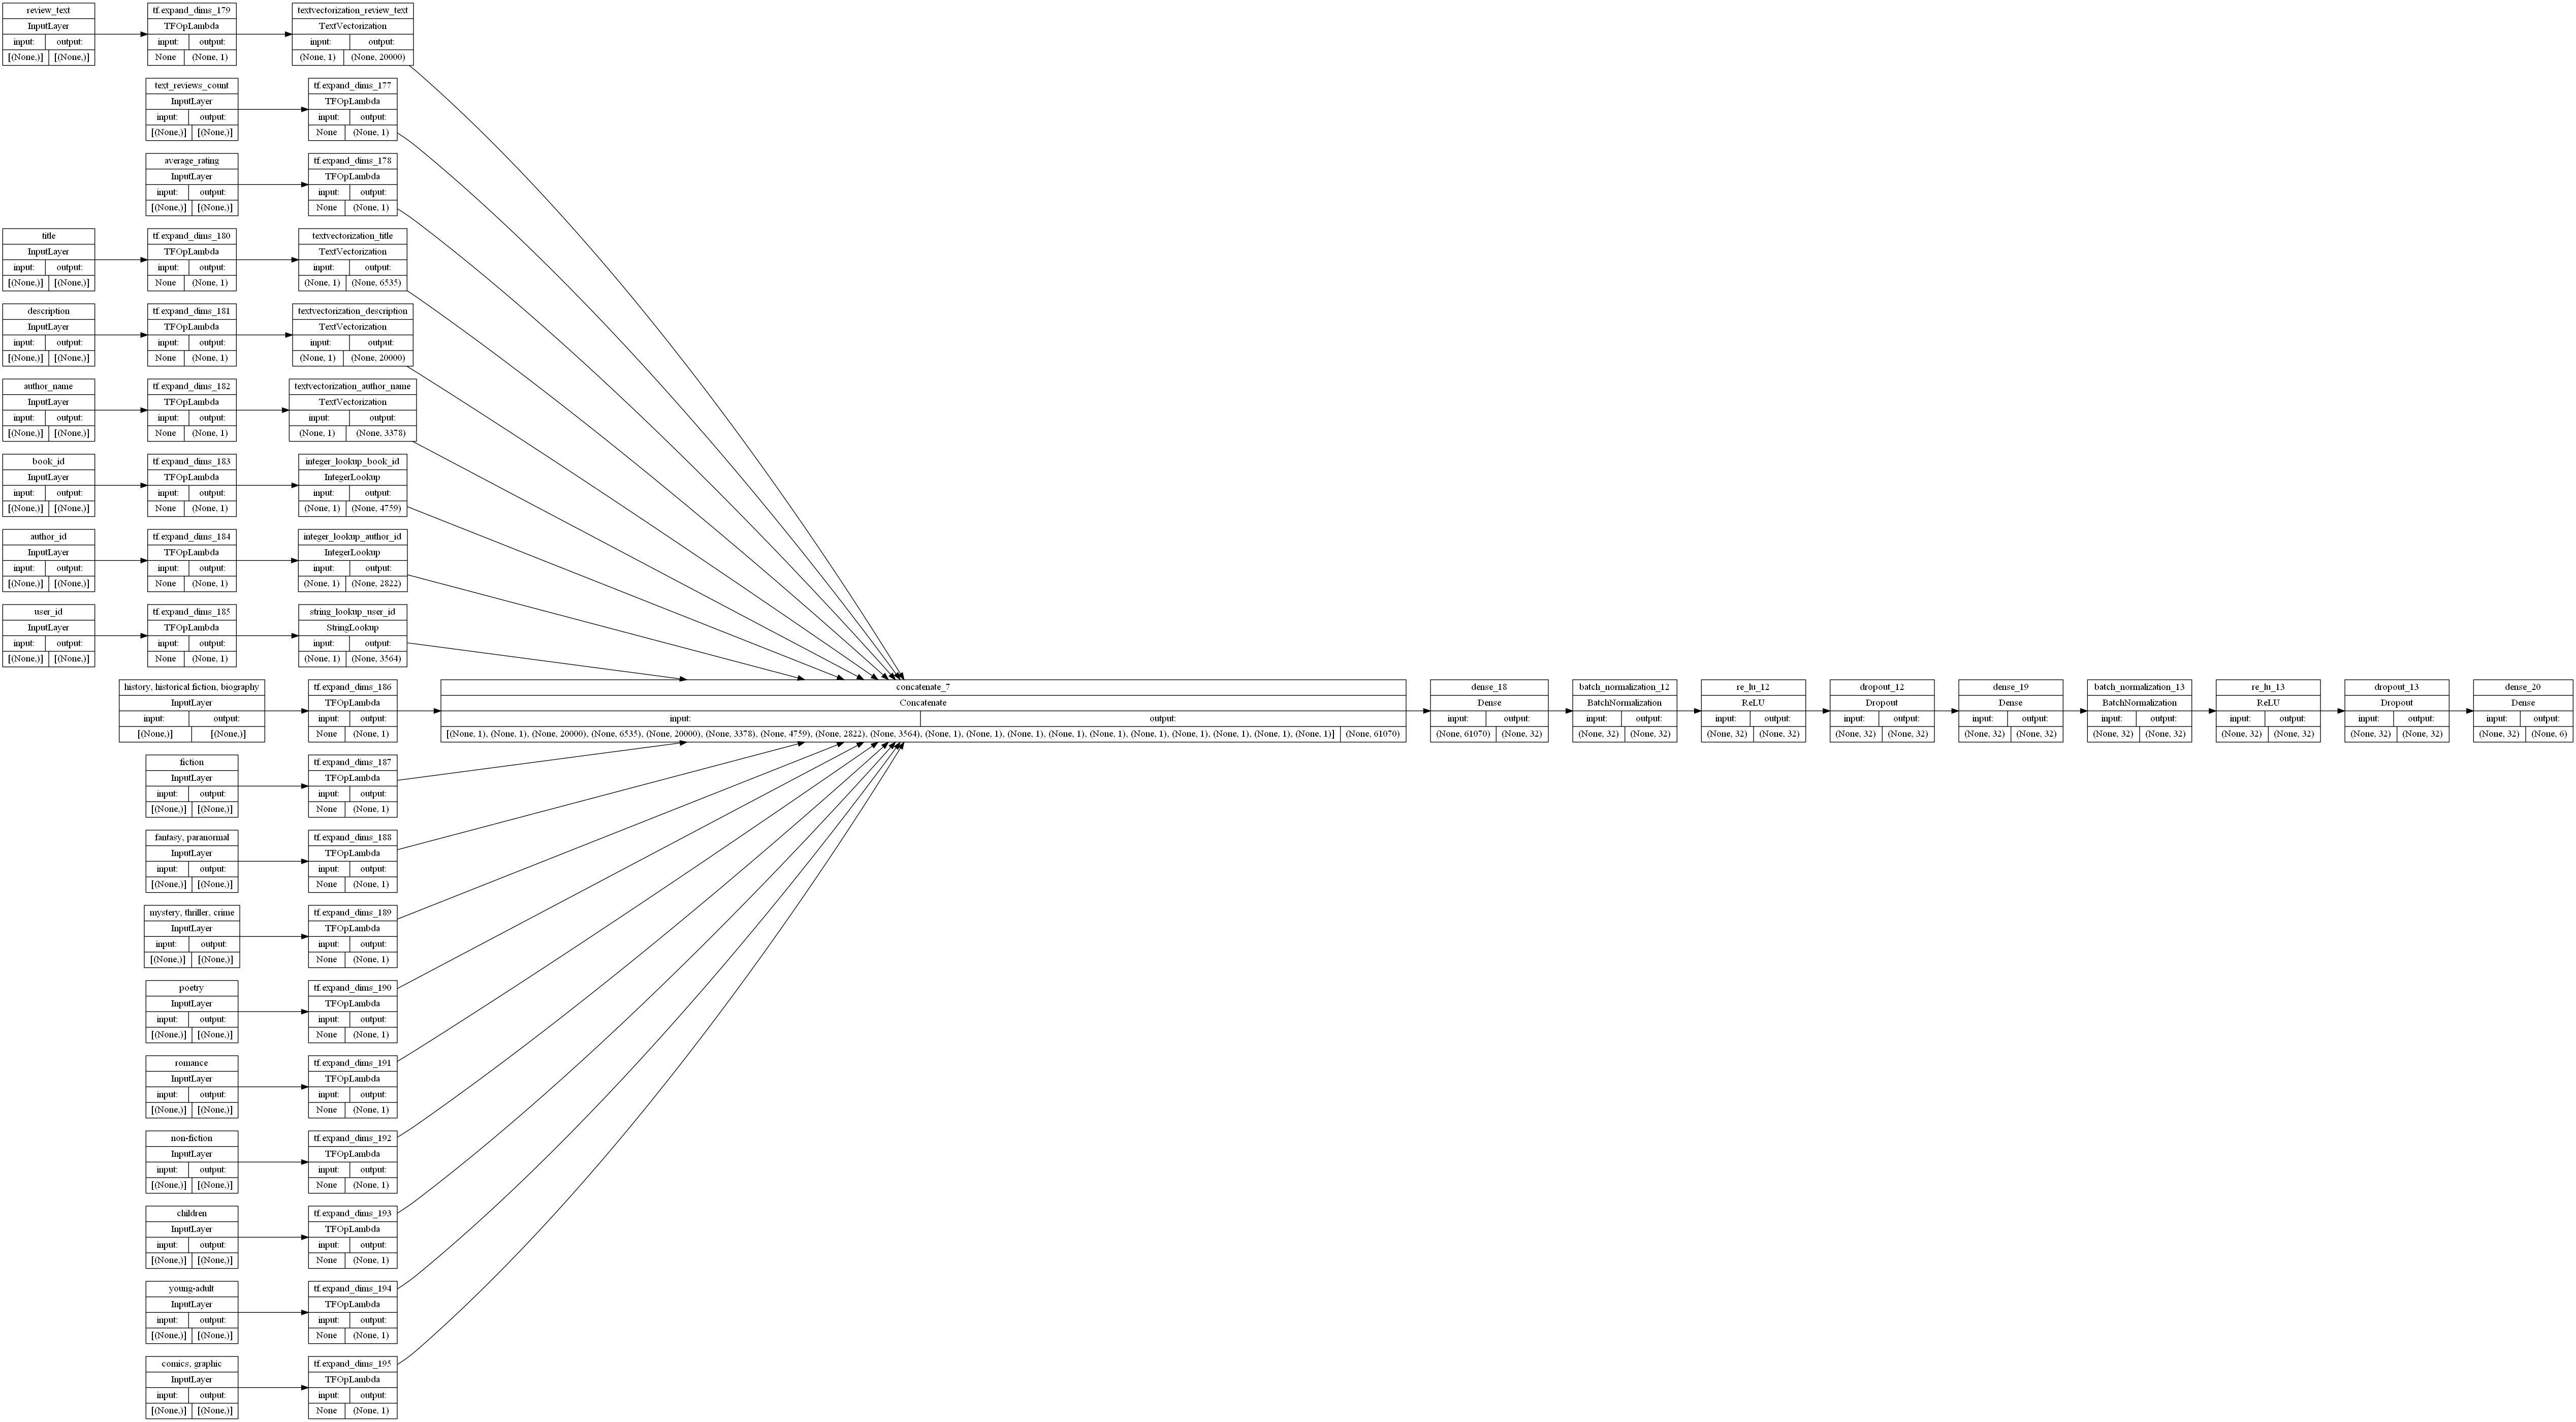

In [148]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, to_file="baseline_model_220121.png", show_shapes=True, rankdir="LR")